# <font color='#797983'> **Deep Learning | Primavera 2024.**
### <font color='#1A2478'> **Instituto Tecnológico y de Estudios Superiores de Occidente**.

**<font color='#797983'>Nombre:** Contreras Figueroa Javier Alejandro
   
**<font color='#797983'>Profesor:** Amezcua Ivan.
   
**<font color='#797983'>Fecha:** 29/Febrero/2024
   
## <font color='#797983'> ** Proyecto l: Autoencoders **

In [1]:
pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=eb2fe4e66cab79493085d00694b54c7d7933dae11efec2740d15e56a62a46800
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


Trabajaremos con los datos que se encuentran en el MedMNIST, el cual presenta diferentes dataset de cuestiones medicas, de las cuales pueden ser con imagenes 2D o imagenes en 3D.

In [2]:
#train_dataset = BloodMNIST(split="train", download=True)
#val_dataset = BloodMNIST(split="val", download=True)
#test_dataset = BloodMNIST(split="test", download=True, size=224)

In [3]:
from tensorflow.keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error
from tensorflow.keras import backend as K
import numpy as np
from medmnist import BloodMNIST, PathMNIST

In [4]:
dataset = BloodMNIST(split="train", download=True, size =64)
dataset_val = BloodMNIST(split="val", download=True, size=64)
dataset_test = BloodMNIST(split="test", download=True, size=64)

100%|██████████| 156251765/156251765 [00:09<00:00, 16951304.53it/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist_64.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist_64.npz


In [5]:
import medmnist
print(medmnist.__version__)

3.0.1


In [6]:
dataset

Dataset BloodMNIST of size 64 (bloodmnist_64)
    Number of datapoints: 11959
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: C

In [7]:
# Bueno cargados los datos, asignamos las imagenes en nuevas varibales
x_train = dataset.imgs
x_val = dataset_val.imgs
x_test = dataset_test.imgs

In [8]:
print(f'Train data: {x_train.shape}')
print(f'Validation data: {x_val.shape}')
print(f'Test data: {x_test.shape}')

Train data: (11959, 64, 64, 3)
Validation data: (1712, 64, 64, 3)
Test data: (3421, 64, 64, 3)


- Con esto corroboramos que son la cantidad de imagenes que nos proporciona o menciona en la pagina es correcto.

In [9]:
print("Valor mínimo de la imagen:", np.min(x_train))
print("Valor máximo de la imagen:", np.max(x_train))

Valor mínimo de la imagen: 8
Valor máximo de la imagen: 255


In [10]:
x_train.dtype

dtype('uint8')

Tambien corroboramos si es necesario normalizar, parece que los valores se encuentran de 0 a 255, y no son de tipo al float, por cuestion de trabajo, los transformare a float32 y normalizaremos para que el rango vaya de 0 a 1.

In [11]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_val = x_val.astype('float32')/255
print("Valor mínimo de la imagen:", np.min(x_train))
print("Valor máximo de la imagen:", np.max(x_train))

Valor mínimo de la imagen: 0.03137255
Valor máximo de la imagen: 1.0


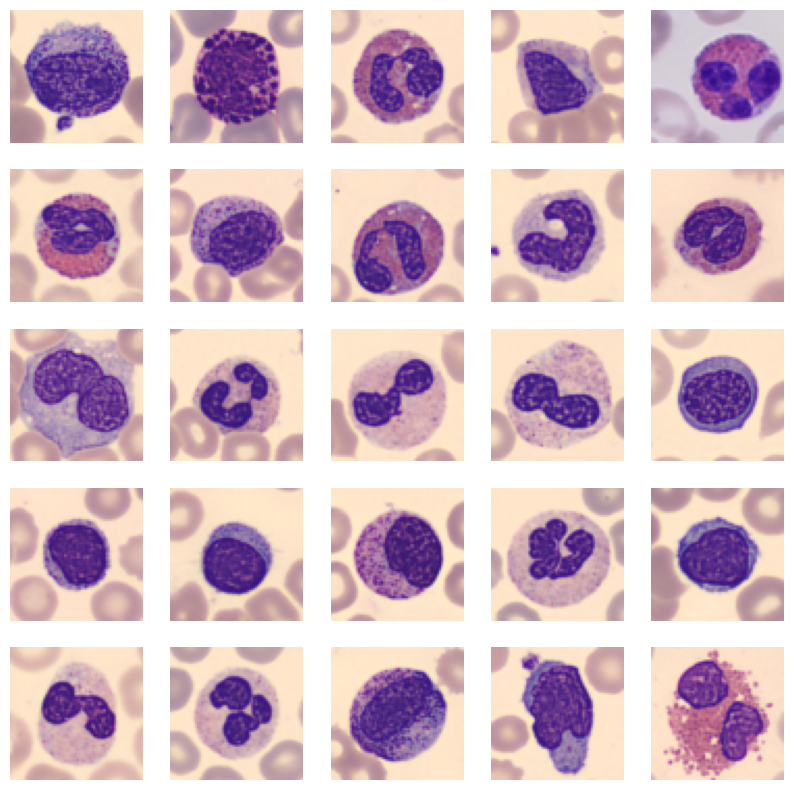

In [12]:
import matplotlib.pyplot as plt
import numpy as np
# Graficar algunas imágenes de prueba
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[i])
    plt.axis('off')
plt.show()

## MODEL

In [13]:
print(f'Train data: {x_train.shape}')
print(f'Validation data: {x_val.shape}')
print(f'Test data: {x_test.shape}')

Train data: (11959, 64, 64, 3)
Validation data: (1712, 64, 64, 3)
Test data: (3421, 64, 64, 3)


In [14]:
#def Autoencoder_Model(input_shape=(64, 64, 3)):
input_shape=(64, 64, 3)
encoding_dim = 80
    # Input
input_img = Input(shape=input_shape)

    # Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.2)(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
encoded = Dense(128, activation='relu')(x)

    # Decoder
x = Dense(16 * 16 * 8, activation='relu')(encoded)
x = Reshape((16, 16, 8))(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)


    # Model
autoencoder = Model(input_img, decoded)
    #return autoencoder


#autoencoder = Autoencoder_Model()
#autoencoder.summary()


### AUTOENCODER

In [15]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 8)         0         
 g2D)                                                        

In [16]:
#autoencoder = Autoencoder_Model()

In [17]:
#decoded_layer1 = autoencoder.layers[-2]
#decoded_layer2 = autoencoder.layers[-1]

#encoded_input = Input(shape=(encoding_dim,))
#decoder = Model(encoded_input, decoded_layer2(decoded_layer1(encoded_input)))

In [18]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [19]:
#autoencoder.layers

### Training

In [20]:
autoencoder.fit(
    x_train,
    x_train,
    batch_size = 32,
    epochs = 2,
    validation_data = (x_val, x_val)
)

Epoch 1/2
374/374 [==============================] - 11s 11ms/step - loss: 0.5247 - val_loss: 0.5163
Epoch 2/2
374/374 [==============================] - 3s 9ms/step - loss: 0.5022 - val_loss: 0.5072


In [21]:
encoded_images = autoencoder.predict(x_test)
print(f'Dimension del encodeado: {encoded_images.shape}')

107/107 [==============================] - 1s 5ms/step
Dimension del encodeado: (3421, 64, 64, 3)


In [22]:
decoder_model = Model(input_img, decoded)
predicted_images = decoder_model.predict(encoded_images)
print(predicted_images.shape)
print(f'Dimension del decodeado: {predicted_images.shape}')

107/107 [==============================] - 0s 2ms/step
(3421, 64, 64, 3)
Dimension del decodeado: (3421, 64, 64, 3)


## Visualización

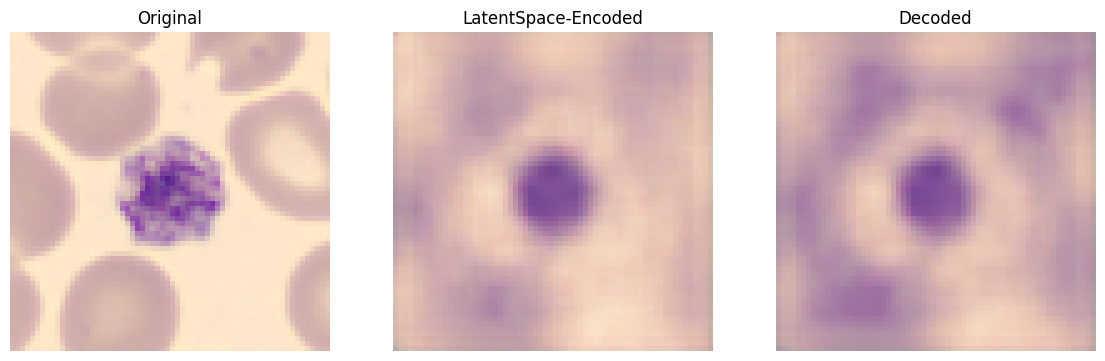

In [23]:
import matplotlib.pyplot as plt
def plot_images(original, encoded, decoded):
    n = len(original)
    plt.figure(figsize=(14, 6))
    for i in range(n):
        # Original
        plt.subplot(1, 3, 1)
        plt.imshow(original[i])
        plt.axis('off')
        plt.title('Original')

        # Encoded
        plt.subplot(1, 3, 2)
        plt.imshow(encoded[i].reshape(64, 64, 3))
        plt.axis('off')
        plt.title('LatentSpace-Encoded')

        # Decoded
        plt.subplot(1, 3, 3)
        plt.imshow(decoded[i])
        plt.axis('off')
        plt.title('Decoded')
    plt.show()


plot_images(x_test[:122], encoded_images[:122], predicted_images[:122])


In [24]:
from skimage.metrics import structural_similarity as ssim

# Calcular SSIM entre las imágenes originales y las imágenes decodificadas
ssim_scores = []
for i in range(len(x_test)):
    ssim_score = ssim(x_test[i], predicted_images[i], multichannel=True)
    ssim_scores.append(ssim_score)

average_ssim = sum(ssim_scores) / len(ssim_scores)
print(f"\nAverage SSIM Score: {average_ssim}")

# - https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.structural_similarity

<ipython-input-24-66e96f123034>:6: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(x_test[i], predicted_images[i], multichannel=True)



Average SSIM Score: 0.6694732263435993


In [25]:
y_test = dataset_test.labels

107/107 [==============================] - 0s 3ms/step


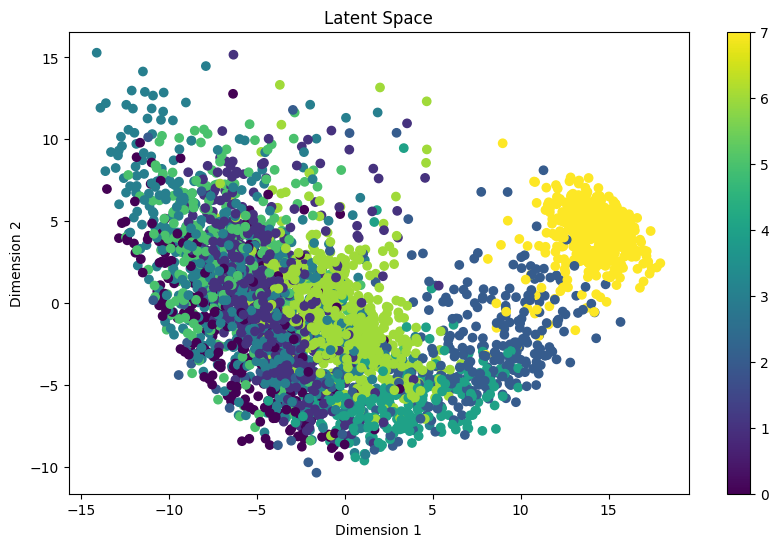

In [26]:
from sklearn.decomposition import PCA

# Obtener las representaciones latentes de un conjunto de datos de entrada
encoded_images = autoencoder.predict(x_test)

# Reducir la dimensionalidad a 2D para visualización
pca = PCA(n_components=2)
latent_space = pca.fit_transform(encoded_images.reshape(encoded_images.shape[0], -1))

# Graficar el espacio latente
plt.figure(figsize=(10, 6))
plt.scatter(latent_space[:, 0], latent_space[:, 1],c=y_test, cmap='viridis')
plt.colorbar()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Latent Space')
plt.show()


## Introducimos el Ruido

- Los ruidos recomendados para este tipo de imagenes son el Gaussiano y Speckle.

In [27]:
# Gaussiano

def add_gaussian_noise(data, mean=0, std=0.1):
    noise = np.random.normal(mean, std, data.shape)
    noisy_data = data + noise
    return np.clip(noisy_data, 0., 1.).astype(np.float32)

x_train_Gnoisy = add_gaussian_noise(x_train, mean=0.2, std=0.5)
x_val_Gnoisy = add_gaussian_noise(x_val, mean=0.2, std=0.5)
x_test_Gnoisy = add_gaussian_noise(x_test, mean=0.2, std=0.5)



In [28]:
#print(np.max(x_train_Gnoisy)), print(np.max(x_val_Gnoisy)), print(np.max(x_test_Gnoisy))

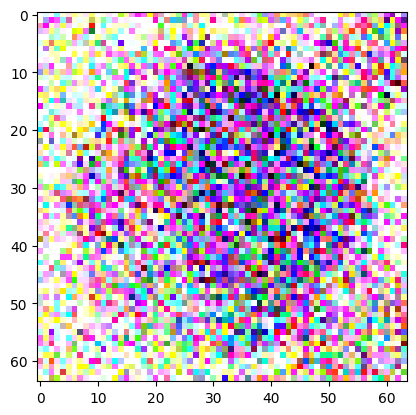

In [29]:
plt.imshow(x_train_Gnoisy[1].reshape(64,64,3))

## Model with Gaussian Noise

In [30]:
#autoencoder_gaussian = Autoencoder_Model()
autoencoder_gaussian = Model(input_img, decoded)
autoencoder_gaussian.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder_gaussian.fit(
    x_train_Gnoisy,
    x_train,
    batch_size = 32,
    epochs = 20,
    validation_data = (x_val_Gnoisy, x_val)
)

Epoch 1/20
374/374 [==============================] - 6s 10ms/step - loss: 0.5043 - val_loss: 0.5108
Epoch 2/20
374/374 [==============================] - 3s 8ms/step - loss: 0.5014 - val_loss: 0.5080
Epoch 3/20
374/374 [==============================] - 3s 8ms/step - loss: 0.5002 - val_loss: 0.5079
Epoch 4/20
374/374 [==============================] - 3s 9ms/step - loss: 0.4992 - val_loss: 0.5060
Epoch 5/20
374/374 [==============================] - 3s 8ms/step - loss: 0.4985 - val_loss: 0.5034
Epoch 6/20
374/374 [==============================] - 3s 8ms/step - loss: 0.4978 - val_loss: 0.5024
Epoch 7/20
374/374 [==============================] - 3s 8ms/step - loss: 0.4973 - val_loss: 0.5008
Epoch 8/20
374/374 [==============================] - 3s 9ms/step - loss: 0.4969 - val_loss: 0.5001
Epoch 9/20
374/374 [==============================] - 3s 8ms/step - loss: 0.4965 - val_loss: 0.5009
Epoch 10/20
374/374 [==============================] - 3s 8ms/step - loss: 0.4961 - val_loss: 0.500

In [31]:
encoded_images = autoencoder_gaussian.predict(x_test_Gnoisy)
print(f'Dimension del encodeado(LatentSpace): {encoded_images.shape}')
print(" ")


#decoder_model = Autoencoder_Model()
decoder_model = Model(input_img, decoded)
predicted_images = decoder_model.predict(encoded_images)
print(predicted_images.shape)
print(f'Dimension del decodeado: {predicted_images.shape}')

107/107 [==============================] - 1s 4ms/step
Dimension del encodeado(LatentSpace): (3421, 64, 64, 3)
 
107/107 [==============================] - 0s 2ms/step
(3421, 64, 64, 3)
Dimension del decodeado: (3421, 64, 64, 3)


Text(0.5, 1.0, 'Salida')

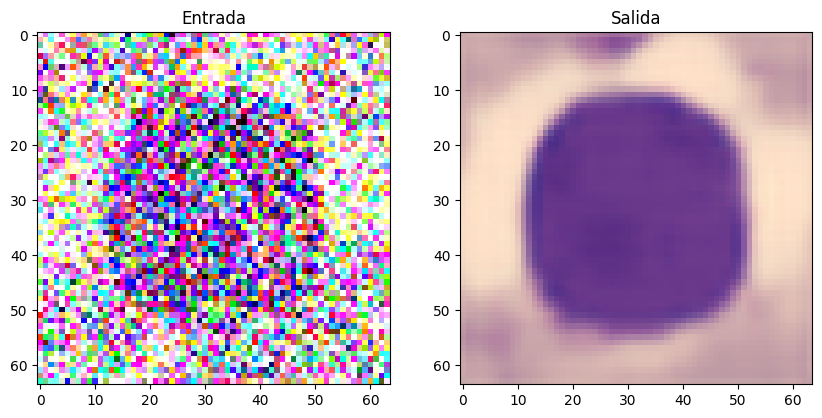

In [32]:
f = plt.figure(figsize=(10,10))
f.add_subplot(1, 2, 1)
plt.imshow(x_test_Gnoisy[1].reshape(64,64,3))
plt.title('Entrada')

f.add_subplot(1, 2, 2)
plt.imshow(predicted_images[1].reshape(64,64,3))
plt.title('Salida')

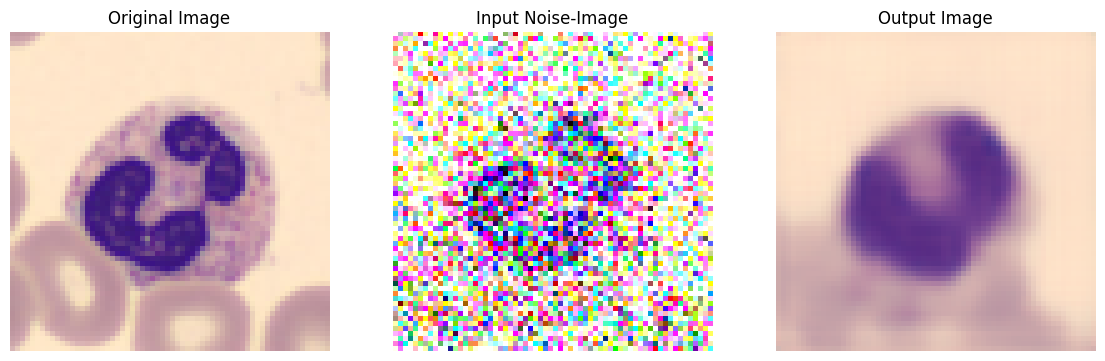

In [33]:
def plot_images(original, encoded, decoded):
    n = len(original)
    plt.figure(figsize=(14, 6))
    for i in range(n):
        # Original
        plt.subplot(1, 3, 1)
        plt.imshow(original[i])
        plt.axis('off')
        plt.title('Original Image')

        # Encoded
        plt.subplot(1, 3, 2)
        plt.imshow(encoded[i].reshape(64, 64, 3))
        plt.axis('off')
        plt.title('Input Noise-Image')

        # Decoded
        plt.subplot(1, 3, 3)
        plt.imshow(decoded[i])
        plt.axis('off')
        plt.title('Output Image')
    plt.show()


plot_images(x_test[:12], x_test_Gnoisy[:12], predicted_images[:12])

In [34]:
# Calcular SSIM entre las imágenes originales y las imágenes decodificadas
ssim_scores = []
for i in range(len(x_test)):
    ssim_score = ssim(x_test[i], predicted_images[i], multichannel=True)
    ssim_scores.append(ssim_score)

average_ssim = sum(ssim_scores) / len(ssim_scores)
print(f"\nAverage SSIM Score: {average_ssim}")

<ipython-input-34-e6d61a3e3630>:4: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(x_test[i], predicted_images[i], multichannel=True)



Average SSIM Score: 0.7134636291736959


In [35]:
print(f"Average SSIM Score: {average_ssim}")

Average SSIM Score: 0.7134636291736959


## Model with Speckle noise

- Witn Spackle Noise


In [36]:
# Speckle
def add_speckle_noise(data, mean=0, std=0.1):
    noise = np.random.normal(mean, std, data.shape)
    noisy_data = data + data * noise
    return np.clip(noisy_data, 0., 1.).astype(np.float32)


x_train_Snoisy = add_speckle_noise(x_train, mean=0.3, std=0.5)
x_val_Snoisy = add_speckle_noise(x_val, mean=0.3, std=0.5)
x_test_Snoisy = add_speckle_noise(x_test, mean=0.3, std=0.5)


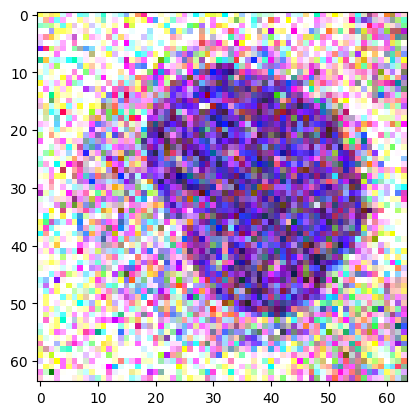

In [37]:
plt.imshow(x_train_Snoisy[1].reshape(64,64,3))

In [48]:
#autoencoder_seckle = Autoencoder_Model()
autoencoder_seckle = Model(input_img, decoded)
autoencoder_seckle.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder_seckle.fit(
    x_train_Snoisy,
    x_train,
    batch_size = 32,
    epochs = 60,
    validation_data = (x_val_Snoisy, x_val)
)

Epoch 1/60
374/374 [==============================] - 5s 9ms/step - loss: 0.4917 - val_loss: 0.4928
Epoch 2/60
374/374 [==============================] - 5s 14ms/step - loss: 0.4911 - val_loss: 0.4926
Epoch 3/60
374/374 [==============================] - 4s 11ms/step - loss: 0.4910 - val_loss: 0.4931
Epoch 4/60
374/374 [==============================] - 3s 8ms/step - loss: 0.4911 - val_loss: 0.4943
Epoch 5/60
374/374 [==============================] - 3s 8ms/step - loss: 0.4910 - val_loss: 0.4942
Epoch 6/60
374/374 [==============================] - 4s 10ms/step - loss: 0.4910 - val_loss: 0.4930
Epoch 7/60
374/374 [==============================] - 4s 11ms/step - loss: 0.4910 - val_loss: 0.4933
Epoch 8/60
374/374 [==============================] - 3s 8ms/step - loss: 0.4909 - val_loss: 0.4924
Epoch 9/60
374/374 [==============================] - 3s 9ms/step - loss: 0.4909 - val_loss: 0.4938
Epoch 10/60
374/374 [==============================] - 3s 8ms/step - loss: 0.4909 - val_loss: 0.

In [49]:
encoded_images = autoencoder_seckle.predict(x_test_Snoisy)
print(f'Dimension del encodeado: {encoded_images.shape}')

#decoder_model = Autoencoder_Model()
decoder_model = Model(input_img,decoded)
predicted_Simages = decoder_model.predict(encoded_images)
print(predicted_images.shape)
print(f'Dimension del decodeado: {predicted_Simages.shape}')

107/107 [==============================] - 0s 3ms/step
Dimension del encodeado: (3421, 64, 64, 3)
107/107 [==============================] - 0s 2ms/step
(3421, 64, 64, 3)
Dimension del decodeado: (3421, 64, 64, 3)


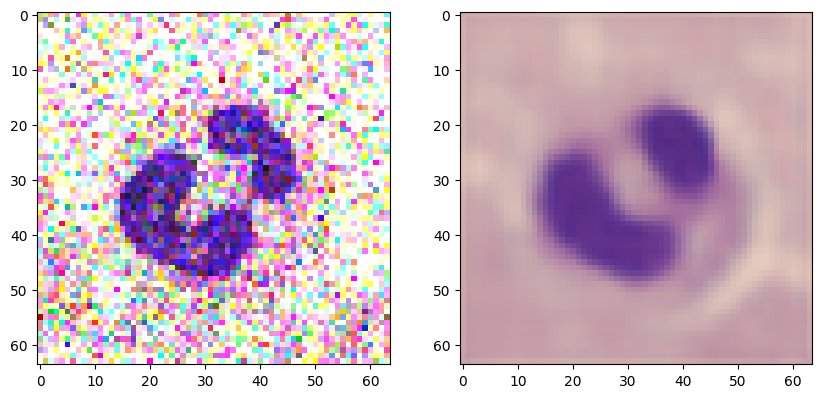

In [50]:
f = plt.figure(figsize=(10,10))
f.add_subplot(1, 2, 1)
plt.imshow(x_test_Snoisy[11].reshape(64,64,3))

f.add_subplot(1, 2, 2)
plt.imshow(predicted_Simages[11].reshape(64,64,3))

In [51]:
def plot_images(original, encoded, decoded):
    n = len(original)
    plt.figure(figsize=(14, 6))
    for i in range(n):
        # Original
        plt.subplot(1, 3, 1)
        plt.imshow(original[i])
        plt.axis('off')
        plt.title('Original Image')

        # Encoded
        plt.subplot(1, 3, 2)
        plt.imshow(encoded[i].reshape(64, 64, 3))
        plt.axis('off')
        plt.title('Input Noise-Image')

        # Decoded
        plt.subplot(1, 3, 3)
        plt.imshow(decoded[i])
        plt.axis('off')
        plt.title('Output Image')
    plt.show()


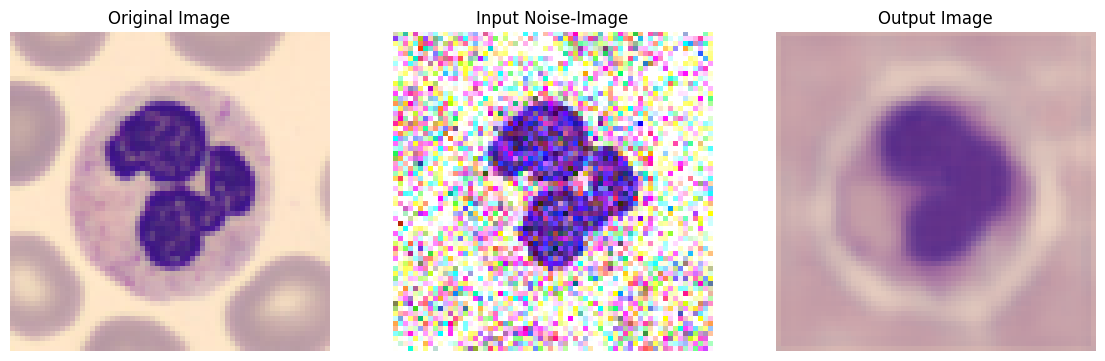

In [52]:
i = 22
plot_images(x_test[:i], x_test_Snoisy[:i], predicted_Simages[:i])

In [53]:
# Calcular SSIM entre las imágenes originales y las imágenes decodificadas
ssim_scores = []
for i in range(len(x_test)):
    ssim_score = ssim(x_test[i], predicted_images[i], multichannel=True)
    ssim_scores.append(ssim_score)

average_ssim = sum(ssim_scores) / len(ssim_scores)
print(f"\nAverage SSIM Score: {average_ssim}")

<ipython-input-53-e6d61a3e3630>:4: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(x_test[i], predicted_images[i], multichannel=True)



Average SSIM Score: 0.7134636291736959


In [58]:
autoencoder_seckle.save('autoencoder_model_specklenoisy.h5')

In [56]:
autoencoder_gaussian.save('autoencoder_model_gaussiannoisy.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
